fatal: destination path 'Bavaria_Colombia' already exists and is not an empty directory.


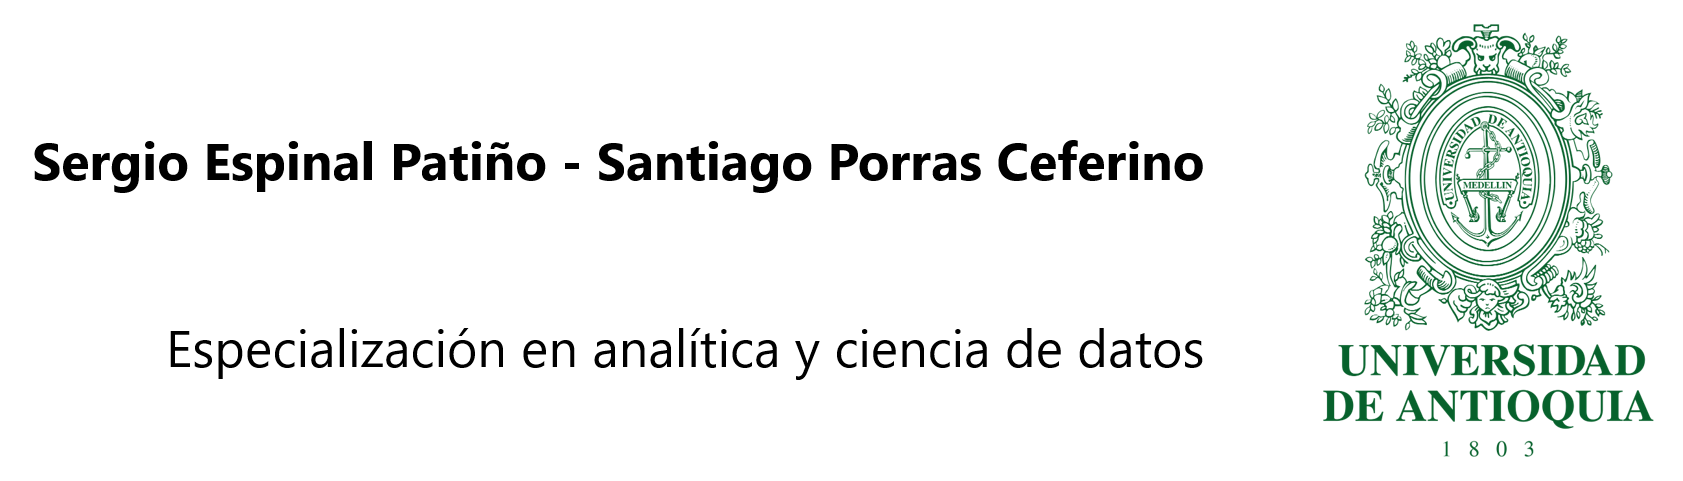

In [42]:
#Importamos el GitHub
! git clone https://github.com/Santiago-Porras/Bavaria_Colombia

from IPython.display import Image
Image("/content/Bavaria_Colombia/img/Imagen1.png")

# Reto Colombia
En Bavaria quieren encontrar la mejor estrategia de impulso, mantenimiento o frenado, de un listado de marcas establecido, con el objetivo de ofrecer el mejor portafolio a los puntos de venta/zonas dependiendo de sus características e historial de compra.​

## Explicación Dataset

- BaseConsolidada.csv = Tabla de clientes con las características de su punto de venta, ubicación e histórico de compra

```
Cliente : Id del Establecimiento (Llave primaria)
Regional2: Región donde se encuentra ubicado (Conjunto de departamentos)
Gerencia2: Gerencia que le distribuye el producto (Conjunto de 1, 2 o mas ciudades)
SubCanal2: Tipo de establecimiento: (Tienda, Bar, etc)
Categoria: Variable definida por AB-Inbev para calificar la importancia de un establecimiento dada su compra histórica.
Nevera: Variable dummie que me permite ver si el establecimiento tiene o no una nevera en su punto de venta.
Año: Año en el que se realiza la compra
Mes: Mes en el que se realiza la compra
Cliente: Id del establecimiento
SegmentoPrecio2: Categoría de la marca, dado el ingreso por litro a la compañía.
Marca2: Marca vendida
Cupo2: Tipo de envase de la marca vendida
CapacidadEnvase2: Capacidad en volumen, de la Marca2-Cupo2 vendido.
Volumen: Cantidad de volumen vendido de la Marca-Cupo2-CapacidadEnvase2
disc: Descuentos otorgados al establecimiento por la compra
nr: NetRevenue que dejó la venta a la compañía.
```

 ## ¿Qué construir?
El objetivo es encontrar la probabilidad de que un cliente compre cada una de las marcas dadas, con el fin de asignar la estrategia adecuada a cada uno de ellos.​

Para esto se creará un modelo que estime la probabilidad de compra del cliente.

Ver el Brewing Data Cup:

* [Link](https://github.com/Santiago-Porras/Bavaria_Colombia)

# Cargue de librerias para trabajar:

In [43]:
#Importamos Librerías

#Python
from datetime import datetime, timedelta,date
import pandas as pd
import numpy as np
from numpy import mean
from datetime import datetime

#Otras
from __future__ import division
import warnings
warnings.filterwarnings("ignore")

#Gráficos
%matplotlib inline
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objects as go
import seaborn as sns

#Imbalanced-learn - Scikit Learn
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

#Scikit Learn
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import tree
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#XgBoost para el Clasificador
import xgboost as xgb

In [44]:
#Descomprimimos el conjunto de datos:
!unrar x -Y "/content/Bavaria_Colombia/data/Base_Consolidada.rar" "/content/drive/path/output_folder/"

#Importamos el conjunto de datos:
base_nueva = pd.read_csv("/content/drive/path/output_folder/BaseConsolidada.csv")
base_nueva = base_nueva.fillna("")
base_nueva['Fecha'] = pd.to_datetime(base_nueva['Fecha'], format='%Y/%m/%d')
base_nueva


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Bavaria_Colombia/data/Base_Consolidada.rar

Extracting  /content/drive/path/output_folder/BaseConsolidada.csv          0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 

,Id,Fecha,Anio,Mes,Cliente,Regional2,Gerencia2,SubCanal2,Categoria,Nevera,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr
0,1,2019-05-01,2019,5,10,Regional 1,Gerencia_3,Subcanal_1,Categoria_2,1,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567
1,2,2019-05-01,2019,5,10,Regional 1,Gerencia_3,Subcanal_1,Categoria_2,1,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463
2,3,2019-05-01,2019,5,10,Regional 1,Gerencia_3,Subcanal_1,Categoria_2,1,SegmentoPrecio_2,Marca_3,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,359.625828
3,4,2019-05-01,2019,5,10,Regional 1,Gerencia_3,Subcanal_1,Categoria_2,1,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_16,0.026345,-31.065261,134.748399
4,5,2019-05-01,2019,5,10,Regional 1,Gerencia_3,Subcanal_1,Categoria_2,1,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,0.086938,0.000000,496.901005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406111,1406112,2020-09-01,2020,9,20414,Regional 1,Gerencia_1,Subcanal_3,Categoria_1,0,SegmentoPrecio_3,Marca_39,Cupo_2,CapacidadEnvase_10,0.000000,0.000000,0.000000
1406112,1406113,2020-09-01,2020,9,20456,Regional 1,Gerencia_10,Subcanal_1,Categoria_2,0,SegmentoPrecio_1,Marca_38,Cupo_2,CapacidadEnvase_10,0.009780,0.000000,62.777534
1406113,1406114,2020-09-01,2020,9,20456,Regional 1,Gerencia_10,Subcanal_1,Categoria_2,0,SegmentoPrecio_3,Marca_39,Cupo_2,CapacidadEnvase_10,0.009780,0.000000,122.985374
1406114,1406115,2020-09-01,2020,9,20580,Regional 1,Gerencia_10,Subcanal_5,Categoria_6,0,SegmentoPrecio_1,Marca_38,Cupo_2,CapacidadEnvase_10,0.000000,0.000000,0.000000


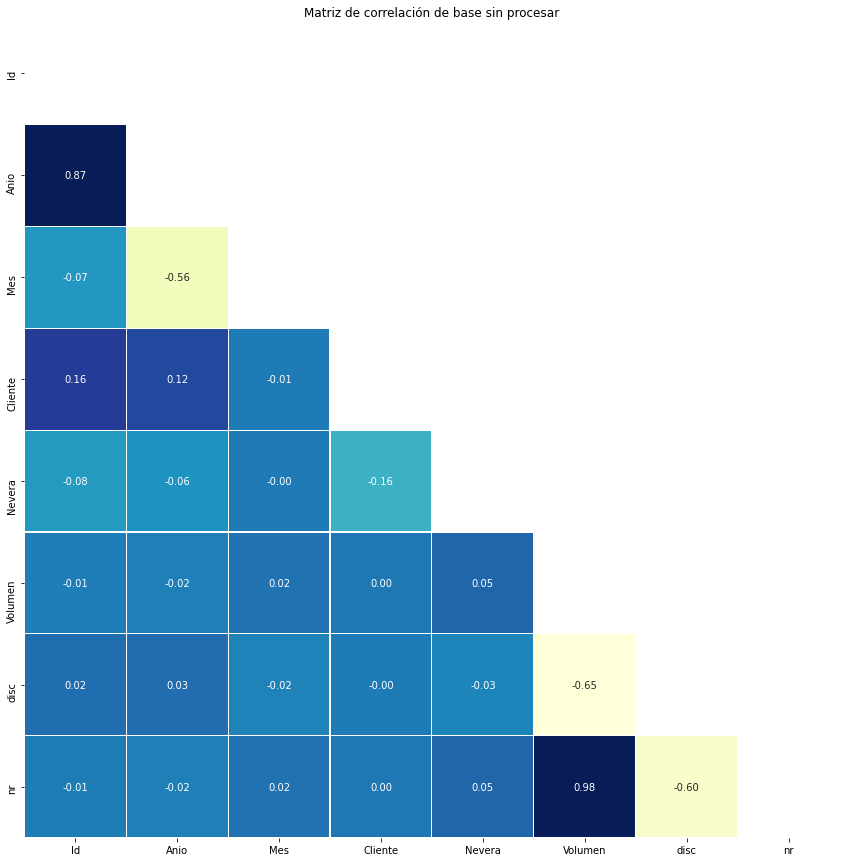

In [45]:
baseCorrPPal = base_nueva[base_nueva.columns].corr()
mask = np.zeros_like(baseCorrPPal)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (15,15))
sns.heatmap(baseCorrPPal,
            annot = True,
            cbar = False,
            mask=mask,
            vmax=.3, 
            square=True,
            linewidths=0.1, 
            fmt=".2f", 
            cmap = "YlGnBu")
plt.title("Matriz de correlación de base sin procesar")
plt.show()

---
* Como podemos observar no hay una correlación de variables que realmente nos demuestre algo
---

In [46]:
#base_nueva = base_nueva.query("Marca_1 == 1")
#base_nueva.head(5)

In [47]:
#Dividimos Histórico + 1 mes
baseHist = base_nueva[(base_nueva['Fecha'] <= datetime(2020,7,1))].reset_index(drop=True)
baseSigMes = base_nueva[(base_nueva['Fecha'] >= datetime(2020,8,1))].reset_index(drop=True)

In [48]:
print(baseHist.Fecha.unique())

['2019-05-01T00:00:00.000000000' '2019-06-01T00:00:00.000000000'
 '2019-07-01T00:00:00.000000000' '2019-08-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-10-01T00:00:00.000000000'
 '2019-11-01T00:00:00.000000000' '2019-12-01T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000' '2020-02-01T00:00:00.000000000'
 '2020-03-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000'
 '2020-05-01T00:00:00.000000000' '2020-06-01T00:00:00.000000000'
 '2020-07-01T00:00:00.000000000']


In [49]:
print(baseSigMes.Fecha.unique())

['2020-08-01T00:00:00.000000000' '2020-09-01T00:00:00.000000000']


In [50]:
baseUsuarios = pd.DataFrame(baseHist['Cliente'].unique())
baseUsuarios.columns = ['Cliente']
baseUsuarios.head()

,Cliente
0,10
1,12
2,14
3,15
4,18


In [51]:
baseUsuarios.shape

(16056, 1)

In [52]:
baseSigMes_1Compra = baseSigMes.groupby('Cliente').Fecha.min().reset_index()

In [53]:
baseSigMes_1Compra.columns = ['Cliente','FechaProxCompra']

In [54]:
baseSigMes_1Compra.shape

(14831, 2)

In [55]:
FechaUltCompra = baseHist.groupby('Cliente').Fecha.max().reset_index()
FechaUltCompra.columns = ['Cliente','FechaUltCompra']
FechaUltCompra.head()

,Cliente,FechaUltCompra
0,1,2020-07-01
1,2,2020-07-01
2,3,2020-07-01
3,4,2020-07-01
4,5,2020-07-01


In [56]:
FechaUltCompra.shape

(16056, 2)

In [57]:
baseFechasCompra = pd.merge(FechaUltCompra,baseSigMes_1Compra,on='Cliente',how='left')
baseFechasCompra['DiasSigCompra'] = (baseFechasCompra['FechaProxCompra'] - baseFechasCompra['FechaUltCompra']).dt.days
baseFechasCompra.head(1200)

,Cliente,FechaUltCompra,FechaProxCompra,DiasSigCompra
0,1,2020-07-01,2020-08-01,31.0
1,2,2020-07-01,2020-08-01,31.0
2,3,2020-07-01,2020-08-01,31.0
3,4,2020-07-01,2020-08-01,31.0
4,5,2020-07-01,2020-08-01,31.0
...,...,...,...,...
1195,1486,2020-06-01,2020-09-01,92.0
1196,1487,2020-07-01,2020-08-01,31.0
1197,1488,2020-07-01,2020-08-01,31.0
1198,1489,2020-07-01,2020-08-01,31.0


In [58]:
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra[['Cliente','DiasSigCompra']],on='Cliente',how='left')
baseUsuarios.head()

,Cliente,DiasSigCompra
0,10,31.0
1,12,153.0
2,14,31.0
3,15,31.0
4,18,31.0


In [59]:
baseUsuarios.describe()

,Cliente,DiasSigCompra
count,16056.000000,13877.000000
mean,9340.670154,51.349283
std,5397.174705,58.962973
min,1.000000,31.000000
25%,4607.750000,31.000000
50%,9290.000000,31.000000
75%,13967.250000,31.000000
max,20580.000000,489.000000


## Recencia

* Calcularemos los días transcurridos desde la última compra por cada uno de los clientes

In [60]:
baseDiasRecencia = baseHist.groupby('Cliente').Fecha.max().reset_index()
baseDiasRecencia.columns = ['Cliente','FechaUltCompra']

In [61]:
baseDiasRecencia['Recencia'] = (baseDiasRecencia['FechaUltCompra'].max() - baseDiasRecencia['FechaUltCompra']).dt.days

In [62]:
baseUsuarios = pd.merge(baseUsuarios, baseDiasRecencia[['Cliente','Recencia']], on='Cliente')

In [63]:
baseUsuarios.head()

,Cliente,DiasSigCompra,Recencia
0,10,31.0,0
1,12,153.0,122
2,14,31.0,0
3,15,31.0,0
4,18,31.0,0


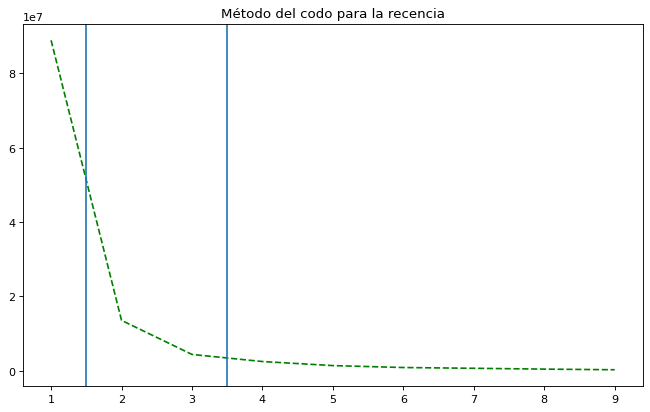

In [64]:
baseRecenciaClust = baseUsuarios[['Recencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseRecenciaClust)
    distancias.append(grupos.inertia_)
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(rango, distancias, color="green", linewidth=1.5, linestyle="--")
plt.axvline(1.5, 0, 1, label='Rango de posibles grupos')
plt.axvline(3.5, 0, 1)
plt.title('Método del codo para la recencia')
plt.show()

In [65]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(baseUsuarios[['Recencia']])
baseUsuarios['RecenciaCluster'] = kmeans.predict(baseUsuarios[['Recencia']])

In [66]:
def OrdenCluster(nombreCluster, etiqueta,df,ascending):
    new_nombreCluster = 'new_' + nombreCluster
    clustOrdenados = df.groupby(nombreCluster)[etiqueta].mean().reset_index()
    clustOrdenados = clustOrdenados.sort_values(by=etiqueta,ascending=ascending).reset_index(drop=True)
    clustOrdenados['index'] = clustOrdenados.index
    ClustOrdenAsc = pd.merge(df,clustOrdenados[[nombreCluster,'index']], on=nombreCluster)
    ClustOrdenAsc = ClustOrdenAsc.drop([nombreCluster],axis=1)
    ClustOrdenAsc = ClustOrdenAsc.rename(columns={"index":nombreCluster})
    return ClustOrdenAsc

In [67]:
baseUsuarios = OrdenCluster('RecenciaCluster', 'Recencia',baseUsuarios,False)

In [68]:
baseUsuarios.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,1284.0,245.431464,44.520717,213.0,213.0,243.0,243.0,427.0
1,1495.0,129.775920,20.502880,91.0,122.0,122.0,122.0,182.0
2,13277.0,2.271221,9.675070,0.0,0.0,0.0,0.0,61.0


## Frecuencia

* Calcularemos la cantidad de compras sin tener en cuenta el valor u otras características... El objetivo es mirar qué tan frecuente es el cliente

In [69]:
baseFrecuencia = baseHist.groupby('Cliente').Fecha.count().reset_index()

In [70]:
baseFrecuencia.columns = ['Cliente','Frecuencia']

In [71]:
baseFrecuencia.head()

,Cliente,Frecuencia
0,1,6
1,2,20
2,3,8
3,4,37
4,5,56


In [72]:
baseUsuarios = pd.merge(baseUsuarios, baseFrecuencia, on='Cliente')

In [73]:
baseUsuarios.head()

,Cliente,DiasSigCompra,Recencia,RecenciaCluster,Frecuencia
0,10,31.0,0,2,95
1,14,31.0,0,2,137
2,15,31.0,0,2,156
3,18,31.0,0,2,108
4,24,31.0,0,2,67


In [74]:
baseUsuarios.Frecuencia.describe()

count    16056.000000
mean        75.552005
std         62.264989
min          1.000000
25%         29.000000
50%         61.000000
75%        106.000000
max        517.000000
Name: Frecuencia, dtype: float64

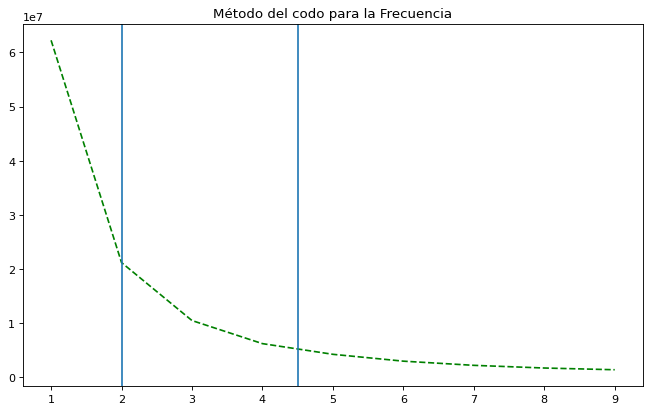

In [75]:
baseFrecuenciaClust = baseUsuarios[['Frecuencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseFrecuenciaClust)
    distancias.append(grupos.inertia_)
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(rango, distancias, color="green", linewidth=1.5, linestyle="--")
plt.axvline(2, 0, 1, label='Rango de posibles grupos')
plt.axvline(4.5, 0, 1)
plt.title('Método del codo para la Frecuencia')
plt.show()

In [76]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Frecuencia']])
baseUsuarios['FrecuenciaCluster'] = kmeans.predict(baseUsuarios[['Frecuencia']])
baseUsuarios = OrdenCluster('FrecuenciaCluster', 'Frecuencia',baseUsuarios,True)
baseUsuarios.groupby('FrecuenciaCluster')['Frecuencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrecuenciaCluster,,,,,,,,
0,6890.0,24.231350,15.041623,1.0,11.0,24.0,37.0,50.0
1,5204.0,76.289777,16.004270,51.0,62.0,75.0,89.0,107.0
2,2899.0,138.345636,21.299660,108.0,120.0,135.0,154.0,185.0
3,1063.0,233.333020,43.332726,186.0,201.0,221.0,253.0,517.0


## Monetización

* La monetización es el total de lo comprado por el cliente, es decir, el valor de sus facturas. En éste caso, no tenemos el valor de lo que compró pero si tenemos el NetRenevue que es la ganancia que deja el cliente a la empresa

In [77]:
baseHist['Monetizacion'] = baseHist['nr']

In [78]:
baseMonetizacion = baseHist.groupby('Cliente').Monetizacion.sum().reset_index()

In [79]:
baseMonetizacion.head()

,Cliente,Monetizacion
0,1,3693.601093
1,2,12711.255742
2,3,3171.736915
3,4,33703.448590
4,5,52418.541133


In [80]:
baseUsuarios = pd.merge(baseUsuarios, baseMonetizacion, on='Cliente')

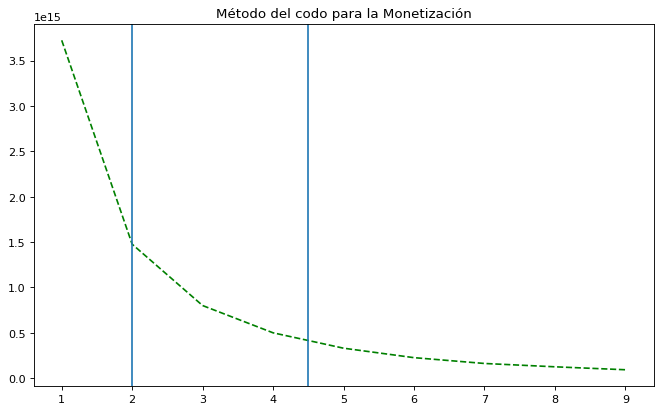

In [81]:
baseMonetizacionClust = baseUsuarios[['Monetizacion']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseMonetizacionClust)
    distancias.append(grupos.inertia_)
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(rango, distancias, color="green", linewidth=1.5, linestyle="--")
plt.axvline(2, 0, 1, label='Rango de posibles grupos')
plt.axvline(4.5, 0, 1)
plt.title('Método del codo para la Monetización')
plt.show()

In [82]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Monetizacion']])
baseUsuarios['MonetizacionCluster'] = kmeans.predict(baseUsuarios[['Monetizacion']])
baseUsuarios = OrdenCluster('MonetizacionCluster', 'Monetizacion',baseUsuarios,True)
baseUsuarios.groupby('MonetizacionCluster')['Monetizacion'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetizacionCluster,,,,,,,,
0,15661.0,8.246624e+04,1.122546e+05,8.780311e+00,1.288356e+04,4.042864e+04,1.024412e+05,7.074502e+05
1,351.0,1.328901e+06,6.084320e+05,7.087878e+05,8.762817e+05,1.143093e+06,1.582759e+06,3.326098e+06
2,34.0,5.475811e+06,1.602221e+06,3.513274e+06,4.026627e+06,5.117106e+06,6.662421e+06,9.214368e+06
3,10.0,1.321442e+07,3.141300e+06,9.974966e+06,1.077873e+07,1.197854e+07,1.541832e+07,1.893108e+07


## Segmentación General

* Generamos un Feature adicional de acuerdo a los clústeres generados para la RFM

In [83]:
baseUsuarios.head()

,Cliente,DiasSigCompra,Recencia,RecenciaCluster,Frecuencia,FrecuenciaCluster,Monetizacion,MonetizacionCluster
0,10,31.0,0,2,95,1,159839.670225,0
1,24,31.0,0,2,67,1,23792.831106,0
2,26,31.0,0,2,89,1,148851.093916,0
3,33,31.0,0,2,56,1,100897.388085,0
4,57,31.0,0,2,105,1,56325.568849,0


In [84]:
baseUsuarios['ScoreGeneral']= baseUsuarios['RecenciaCluster'] + \
                              baseUsuarios['FrecuenciaCluster'] + \
                              baseUsuarios['MonetizacionCluster']

In [85]:
indicadoresGenerales = baseUsuarios.groupby('ScoreGeneral')['Recencia','Frecuencia','Monetizacion'].mean()
indicadoresGenerales

,Recencia,Frecuencia,Monetizacion
ScoreGeneral,,,
0,251.115230,19.641283,1.196597e+04
1,152.736237,32.482334,4.117023e+04
2,15.155079,29.913514,3.289679e+04
3,4.013342,77.544838,8.921970e+04
4,1.067012,137.387634,1.848054e+05
5,0.265049,220.111650,4.262493e+05
6,0.000000,235.395833,1.907347e+06
7,0.000000,253.750000,6.503215e+06
8,0.000000,224.600000,1.217769e+07


In [86]:
#Segmentamos y clasificamos:

baseUsuarios['Segmento'] = 'Valor-Bajo'
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==2,'Segmento'] = 'Valor-Medio' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==3,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==4,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==5,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==6,'Segmento'] = 'Valor-Medio' 

In [87]:
baseAnalisis = baseUsuarios.query("Monetizacion < 5000000 and Frecuencia < 2000")

plot_data = [
    go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Frecuencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Monetizacion'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Frecuencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Monetizacion'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Alto'")['Frecuencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Alto'")['Monetizacion'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetizacion"},
        xaxis= {'title': "Frecuencia"},
        title='Segmentos'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [88]:
baseAnalisis = baseUsuarios.query("Monetizacion < 5000000 and Frecuencia < 250")

plot_data = [
    go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Monetizacion'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Monetizacion'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Alto'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Alto'")['Monetizacion'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Monetizacion"},
        xaxis= {'title': "Recencia"},
        title='Segmentos'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [89]:
baseAnalisis = baseUsuarios
plot_data = [
    go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Frecuencia'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Medio'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Medio'")['Frecuencia'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=baseAnalisis.query("Segmento == 'Valor-Alto'")['Recencia'],
        y=baseAnalisis.query("Segmento == 'Valor-Alto'")['Frecuencia'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frecuencia"},
        xaxis= {'title': "Recencia"},
        title='Segmentos'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [90]:
baseUsuarios.head()

,Cliente,DiasSigCompra,Recencia,RecenciaCluster,Frecuencia,FrecuenciaCluster,Monetizacion,MonetizacionCluster,ScoreGeneral,Segmento
0,10,31.0,0,2,95,1,159839.670225,0,3,Valor-Alto
1,24,31.0,0,2,67,1,23792.831106,0,3,Valor-Alto
2,26,31.0,0,2,89,1,148851.093916,0,3,Valor-Alto
3,33,31.0,0,2,56,1,100897.388085,0,3,Valor-Alto
4,57,31.0,0,2,105,1,56325.568849,0,3,Valor-Alto


In [91]:
#Creamos un dataFrame solamente con el idCliente y la fechaCompra
baseFechasCompra = baseHist[['Cliente','Fecha']]

In [92]:
#Conversión formato fecha
baseFechasCompra['diaCompra'] = baseHist['Fecha'].dt.date

In [93]:
baseFechasCompra = baseFechasCompra.sort_values(['Cliente','Fecha'])

In [94]:
baseFechasCompra

,Cliente,Fecha,diaCompra
781462,1,2020-02-01,2020-02-01
926657,1,2020-04-01,2020-04-01
926658,1,2020-04-01,2020-04-01
982443,1,2020-05-01,2020-05-01
1056872,1,2020-06-01,2020-06-01
...,...,...,...
1213058,20529,2020-07-01,2020-07-01
1213059,20569,2020-07-01,2020-07-01
1213060,20569,2020-07-01,2020-07-01
1213061,20580,2020-07-01,2020-07-01


In [95]:
#Eliminamos duplicados
baseFechasCompra = baseFechasCompra.drop_duplicates(subset=['Cliente','Fecha'],keep='first')

In [96]:
baseFechasCompra.describe()

,Cliente
count,177706.000000
mean,8364.836612
std,4922.769083
min,1.000000
25%,4110.000000
50%,8268.000000
75%,12504.000000
max,20580.000000


In [97]:
#Hacemos un lag para las fechas de compra de acuerdo a los históricos

baseFechasCompra['MesCompra_1'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(1)
baseFechasCompra['MesCompra_2'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(2)
baseFechasCompra['MesCompra_3'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(3)
baseFechasCompra['MesCompra_4'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(4)

In [98]:
baseFechasCompra.head()

,Cliente,Fecha,diaCompra,MesCompra_1,MesCompra_2,MesCompra_3,MesCompra_4
781462,1,2020-02-01,2020-02-01,NaN,NaN,NaN,NaN
926657,1,2020-04-01,2020-04-01,2020-02-01,NaN,NaN,NaN
982443,1,2020-05-01,2020-05-01,2020-04-01,2020-02-01,NaN,NaN
1056872,1,2020-06-01,2020-06-01,2020-05-01,2020-04-01,2020-02-01,NaN
1141036,1,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-02-01


In [99]:
baseFechasCompra['DiasTransc'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_1']).dt.days
baseFechasCompra['DiasTransc2'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_2']).dt.days
baseFechasCompra['DiasTransc3'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_3']).dt.days
baseFechasCompra['DiasTransc4'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_4']).dt.days

In [100]:
baseFechasCompra.head(10)

,Cliente,Fecha,diaCompra,MesCompra_1,MesCompra_2,MesCompra_3,MesCompra_4,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4
781462,1,2020-02-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
926657,1,2020-04-01,2020-04-01,2020-02-01,NaN,NaN,NaN,60.0,NaN,NaN,NaN
982443,1,2020-05-01,2020-05-01,2020-04-01,2020-02-01,NaN,NaN,30.0,90.0,NaN,NaN
1056872,1,2020-06-01,2020-06-01,2020-05-01,2020-04-01,2020-02-01,NaN,31.0,61.0,121.0,NaN
1141036,1,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-02-01,30.0,61.0,91.0,151.0
781463,2,2020-02-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859871,2,2020-03-01,2020-03-01,2020-02-01,NaN,NaN,NaN,29.0,NaN,NaN,NaN
926659,2,2020-04-01,2020-04-01,2020-03-01,2020-02-01,NaN,NaN,31.0,60.0,NaN,NaN
982444,2,2020-05-01,2020-05-01,2020-04-01,2020-03-01,2020-02-01,NaN,30.0,61.0,90.0,NaN
1056873,2,2020-06-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,2020-02-01,31.0,61.0,92.0,121.0


In [101]:
baseDiasCompras = baseFechasCompra.groupby('Cliente').agg({'DiasTransc': ['mean','std']}).reset_index()

In [102]:
baseDiasCompras.columns = ['Cliente', 'DiasTranscMean','DiasTranscStd']

In [103]:
baseDiasCompras.head()

,Cliente,DiasTranscMean,DiasTranscStd
0,1,37.750000,14.840822
1,2,30.200000,0.836660
2,3,30.200000,0.836660
3,4,30.200000,0.836660
4,5,30.333333,0.816497


In [104]:
baseFechasCompra_last = baseFechasCompra.drop_duplicates(subset=['Cliente'],keep='last')

In [105]:
baseFechasCompra_last.head(10)

,Cliente,Fecha,diaCompra,MesCompra_1,MesCompra_2,MesCompra_3,MesCompra_4,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4
1141036,1,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-02-01,30.0,61.0,91.0,151.0
1141037,2,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1141041,3,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1141042,4,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1141048,5,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1141055,6,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1141065,7,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1205975,8,2020-07-01,2020-07-01,2020-03-01,2020-02-01,NaN,NaN,122.0,151.0,NaN,NaN
1193558,9,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-04-01,2020-03-01,30.0,61.0,91.0,122.0
1119413,10,2020-07-01,2020-07-01,2020-06-01,2020-05-01,2020-03-01,2020-02-01,30.0,61.0,122.0,151.0


In [106]:
baseFechasCompra_last = baseFechasCompra_last.dropna()
baseFechasCompra_last = pd.merge(baseFechasCompra_last, baseDiasCompras, on='Cliente')
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra_last[
                                                            ['Cliente',
                                                             'DiasTransc',
                                                             'DiasTransc2',
                                                             'DiasTransc3',
                                                             'DiasTransc4',
                                                             'DiasTranscMean',
                                                             'DiasTranscStd']
                                                            ],on='Cliente')

In [107]:
baseUsuarios.head()

,Cliente,DiasSigCompra,Recencia,RecenciaCluster,Frecuencia,FrecuenciaCluster,Monetizacion,MonetizacionCluster,ScoreGeneral,Segmento,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4,DiasTranscMean,DiasTranscStd
0,10,31.0,0,2,95,1,159839.670225,0,3,Valor-Alto,30.0,61.0,122.0,151.0,32.846154,8.483770
1,24,31.0,0,2,67,1,23792.831106,0,3,Valor-Alto,30.0,61.0,91.0,122.0,30.500000,0.650444
2,26,31.0,0,2,89,1,148851.093916,0,3,Valor-Alto,30.0,122.0,151.0,182.0,35.583333,17.778733
3,33,31.0,0,2,56,1,100897.388085,0,3,Valor-Alto,30.0,61.0,91.0,122.0,30.500000,0.650444
4,57,31.0,0,2,105,1,56325.568849,0,3,Valor-Alto,30.0,61.0,91.0,122.0,30.500000,0.650444


## Get Dummies para categorías:

* Se hace una conversión de datos categóricos a numéricos en columnas para no darle peso a estos valores:

In [108]:
baseGetDummies = baseUsuarios.copy()

In [109]:
baseGetDummies = pd.get_dummies(baseGetDummies)

In [110]:
baseGetDummies.head(10)

,Cliente,DiasSigCompra,Recencia,RecenciaCluster,Frecuencia,FrecuenciaCluster,Monetizacion,MonetizacionCluster,ScoreGeneral,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4,DiasTranscMean,DiasTranscStd,Segmento_Valor-Alto,Segmento_Valor-Bajo,Segmento_Valor-Medio
0,10,31.0,0,2,95,1,159839.670225,0,3,30.0,61.0,122.0,151.0,32.846154,8.483770,1,0,0
1,24,31.0,0,2,67,1,23792.831106,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0
2,26,31.0,0,2,89,1,148851.093916,0,3,30.0,122.0,151.0,182.0,35.583333,17.778733,1,0,0
3,33,31.0,0,2,56,1,100897.388085,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0
4,57,31.0,0,2,105,1,56325.568849,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0
5,58,31.0,0,2,59,1,144728.124337,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0
6,63,31.0,0,2,67,1,42562.809684,0,3,30.0,61.0,151.0,182.0,38.818182,19.265608,1,0,0
7,77,31.0,0,2,104,1,36907.884055,0,3,30.0,122.0,151.0,182.0,35.583333,17.778733,1,0,0
8,89,31.0,0,2,79,1,174381.669667,0,3,30.0,61.0,91.0,151.0,32.846154,8.173597,1,0,0
9,112,31.0,0,2,87,1,61222.209530,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0


In [111]:
baseUsuarios.DiasSigCompra.describe()

count    12444.000000
mean        49.532465
std         54.793464
min         31.000000
25%         31.000000
50%         31.000000
75%         31.000000
max        366.000000
Name: DiasSigCompra, dtype: float64

In [112]:
baseGetDummies['RangoDiasSigCompra'] = 0
baseGetDummies.loc[baseGetDummies.DiasSigCompra<=31,'RangoDiasSigCompra'] = 1
baseGetDummies.loc[baseGetDummies.DiasSigCompra>31,'RangoDiasSigCompra'] = 0

In [113]:
baseGetDummies.RangoDiasSigCompra.unique()

array([1, 0])

In [114]:
baseGetDummies.RangoDiasSigCompra.value_counts()/len(baseUsuarios)*100

1    75.392857
0    24.607143
Name: RangoDiasSigCompra, dtype: float64

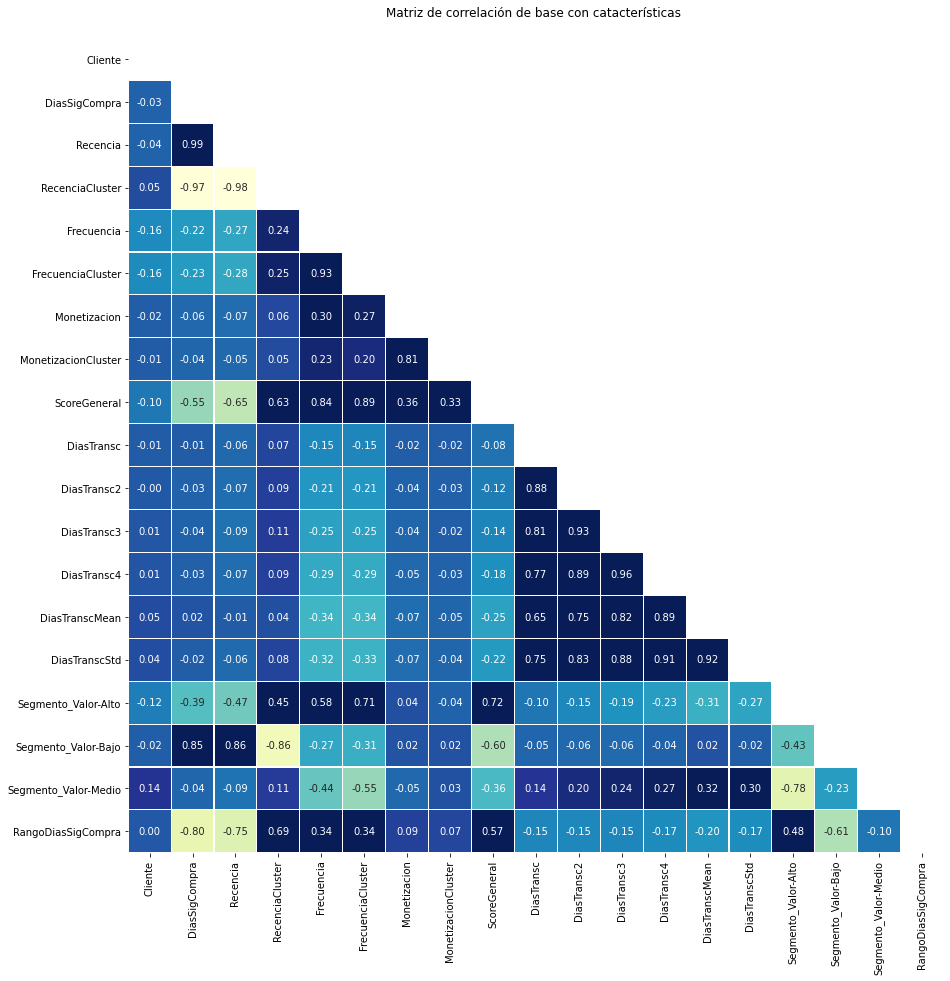

In [115]:
baseCorrCaract = baseGetDummies[baseGetDummies.columns].corr()
mask = np.zeros_like(baseCorrCaract)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (15,15))
sns.heatmap(baseCorrCaract,
            annot = True,
            cbar = False,
            vmax=.3, 
            square=True,
            linewidths=0.1, 
            mask=mask,
            fmt=".2f", 
            cmap = "YlGnBu")
plt.title("Matriz de correlación de base con catacterísticas \n")
plt.show()

---


* Esta base de correlación, a diferencia de la primera, ya es una base que está enriquecida, que tiene correlación entre sus variables y que nos va a permitir entrenar nuestros modelos

* Los segmentos, el ScoreGeneral, la media y la desv. stdr de los días transcurridos ya nos aportan valor al dataset

---

In [116]:
baseGetDummies = baseGetDummies.drop('DiasSigCompra',axis=1)

In [117]:
len(baseGetDummies)

14000

In [118]:
baseGetDummies

,Cliente,Recencia,RecenciaCluster,Frecuencia,FrecuenciaCluster,Monetizacion,MonetizacionCluster,ScoreGeneral,DiasTransc,DiasTransc2,DiasTransc3,DiasTransc4,DiasTranscMean,DiasTranscStd,Segmento_Valor-Alto,Segmento_Valor-Bajo,Segmento_Valor-Medio,RangoDiasSigCompra
0,10,0,2,95,1,1.598397e+05,0,3,30.0,61.0,122.0,151.0,32.846154,8.483770,1,0,0,1
1,24,0,2,67,1,2.379283e+04,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0,1
2,26,0,2,89,1,1.488511e+05,0,3,30.0,122.0,151.0,182.0,35.583333,17.778733,1,0,0,1
3,33,0,2,56,1,1.008974e+05,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0,1
4,57,0,2,105,1,5.632557e+04,0,3,30.0,61.0,91.0,122.0,30.500000,0.650444,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,5788,0,2,190,3,9.974966e+06,3,8,30.0,61.0,91.0,122.0,30.500000,0.650444,0,1,0,1
13996,9794,0,2,216,3,1.088018e+07,3,8,30.0,61.0,91.0,122.0,30.500000,0.650444,0,1,0,1
13997,13069,0,2,228,3,1.074492e+07,3,8,30.0,61.0,91.0,122.0,30.500000,0.650444,0,1,0,1
13998,14357,0,2,249,3,1.893108e+07,3,8,30.0,61.0,91.0,122.0,30.500000,0.650444,0,1,0,1


In [119]:
X, y = baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [120]:
pd.Series(y).value_counts()/len(y)

1    0.753929
0    0.246071
Name: RangoDiasSigCompra, dtype: float64

---
* Acá podemos ver el desbalanceo de clases.... aún así, vamos a mirar qué tal se comportan los modelos sin ir muy al detalle:
---

In [121]:
#Definimos unos modelos clasificadores para ver cómo se comportan c/u 
#con los datos

modelos = []
modelos.append(("XGBClassifier",xgb.XGBClassifier()))
modelos.append(("DecisionTreeClassifier",DecisionTreeClassifier()))
modelos.append(("RandomForestClassifier",RandomForestClassifier()))
modelos.append(("KNeighborsClassifier",KNeighborsClassifier()))
modelos.append(("LogisticRegression",LogisticRegression()))
modelos.append(("GaussianNB",GaussianNB()))
modelos.append(("SVC",SVC()))

In [122]:
modelos

[('XGBClassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1)),
 ('DecisionTreeClassifier',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=None, splitter='best')),
 ('RandomForestClassifier'

In [123]:
print("------------------------------")
print("Score para los Clasificadores:")
print("------------------------------ \n")

for name,model in modelos:

  kfold = KFold(n_splits=5,
                random_state=42,
                shuffle=False)
  
  ScoreAccuracy = cross_val_score(model,
                                  X_train,
                                  y_train, 
                                  cv = kfold,
                                  scoring = "accuracy")
  
  ScoreF1 = cross_val_score(model,
                            X_train,
                            y_train, 
                            cv = kfold,
                            scoring = "f1_weighted")
  
  ScoreR2 = cross_val_score(model,
                            X_train,
                            y_train, 
                            cv = kfold,
                            scoring = "r2")
  
  print("Modelo: ",name," - Accuracy : ",ScoreAccuracy.mean())
  print("Modelo: ",name," - F1 : ",ScoreF1.mean())
  print("Modelo: ",name," - R2 : ",ScoreR2.mean())
  print("------------------------------ \n")

------------------------------
Score para los Clasificadores:
------------------------------ 

Modelo:  XGBClassifier  - Accuracy :  0.9508035714285714
Modelo:  XGBClassifier  - F1 :  0.9489911955211763
Modelo:  XGBClassifier  - R2 :  0.736034414011262
------------------------------ 

Modelo:  DecisionTreeClassifier  - Accuracy :  0.9203571428571429
Modelo:  DecisionTreeClassifier  - F1 :  0.9189166278517222
Modelo:  DecisionTreeClassifier  - R2 :  0.568703864310469
------------------------------ 

Modelo:  RandomForestClassifier  - Accuracy :  0.9475892857142858
Modelo:  RandomForestClassifier  - F1 :  0.9450045449673803
Modelo:  RandomForestClassifier  - R2 :  0.7168277410304225
------------------------------ 

Modelo:  KNeighborsClassifier  - Accuracy :  0.7528571428571429
Modelo:  KNeighborsClassifier  - F1 :  0.7267290157087676
Modelo:  KNeighborsClassifier  - R2 :  -0.328561875726097
------------------------------ 

Modelo:  LogisticRegression  - Accuracy :  0.9486607142857142
Mo

---
* Los tres primeros algoritmos nos dieron buenos score. Como el XGBClassifier es uno de los algoritmos que nos da mejor clasificación, vamos a mirarlo más al detalle para ver cómo se comporta:
---

In [124]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print('Accuracy del XGBClassifier en entrenamiento: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print("\n")
print('Accuracy del XGBClassifier en testeo: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))
print("\n")
y_pred = xgb_model.predict(X_test)
print (classification_report(y_test, y_pred))

Accuracy del XGBClassifier en entrenamiento: 0.95


Accuracy del XGBClassifier en testeo: 0.96


              precision    recall  f1-score   support

           0       1.00      0.82      0.90       674
           1       0.95      1.00      0.97      2126

    accuracy                           0.96      2800
   macro avg       0.97      0.91      0.94      2800
weighted avg       0.96      0.96      0.96      2800



---
* Vamos a hacer uso del GridSearch para ver el comportamiento del clasificador:
---

In [125]:
parametros = {
 'max_depth':range(2,3,5),
 'min_child_weight':range(1,2,4)
}
ParametrosGridSearch = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = parametros, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
ParametrosGridSearch.fit(X_train,y_train)
print("Mejores parámetros: \n")
print(ParametrosGridSearch.best_params_)
print("\n Mejor Score: \n")
print(ParametrosGridSearch.best_score_)

Mejores parámetros: 

{'max_depth': 2, 'min_child_weight': 1}

 Mejor Score: 

0.9513392857142857


In [126]:
xgb_model = xgb.XGBClassifier(max_depth=2, min_child_weight=1).fit(X_train, y_train)
print('Accuracy del Clasificador en entrenamiento: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy del Clasificador en testeo: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy del Clasificador en entrenamiento: 0.95
Accuracy del Clasificador en testeo: 0.96


---
* Ahora vamos a ver cómo se comporta con la clasificación de cada una de las clases:
---

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       674
           1       0.95      1.00      0.97      2126

    accuracy                           0.96      2800
   macro avg       0.97      0.91      0.94      2800
weighted avg       0.96      0.96      0.96      2800



---
* Acá se evidencia que como hay un desbalanceo de clases, las minoritarias están muy mal clasificadas.

* Para éste tipo de problemas se realiza un Undersampling o un Oversampling, aún así, no es tan recomendable para nuestro problema puesto que el problema viene en la delimitación de fronteras.

* En estos casos, para mejorar los clasificadores con problema en delimitación de fronteras para clases desbalanceadas, es recomendable usar un método de BorderlineSMOTE puesto que mejora el aprendizaje a través de un sobremuestreo en las fronteras, generando pesos y sobremuestreo en las fronteras de clases para hacerlas más precisas.

* El muestreo 'not majority': se encarga de remuestrear todas las clases excepto la clase mayoritaria.

* Vamos a ver cómo se comporta con un DecisionTreeClassifier y con un RandomForestClassifier
---

In [128]:
modelDTC = DecisionTreeClassifier()
muestreoDTC = BorderlineSMOTE(random_state=42,
                           sampling_strategy='not majority',
                           n_jobs = 4)

X, y = muestreoDTC.fit_resample(baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelDTC.fit(X_train, y_train,sample_weight=1)
y_pred = modelDTC.predict(X_test)
print('\n Métricas del DecisionTreeClassifier en entrenamiento con BorderlineSMOTE:\n\n')
print(classification_report(y_test, y_pred))


 Métricas del DecisionTreeClassifier en entrenamiento con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2081
           1       0.95      0.95      0.95      2141

    accuracy                           0.95      4222
   macro avg       0.95      0.95      0.95      4222
weighted avg       0.95      0.95      0.95      4222



---
* Como podemos ver el support, ya hay un balanceo de clases por sobremuestreo sintético en las fronteras.

* Vamos a hacerle predicción al modelo ya entrenado y miramos resultados:
---

In [129]:
X,y= baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
print('\n Métricas del DecisionTreeClassifier en testeo con BorderlineSMOTE:\n\n')
y_pred = modelDTC.predict(X_test)
print(classification_report(y_test, y_pred))


 Métricas del DecisionTreeClassifier en testeo con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       674
           1       0.99      0.99      0.99      2126

    accuracy                           0.98      2800
   macro avg       0.97      0.98      0.97      2800
weighted avg       0.98      0.98      0.98      2800



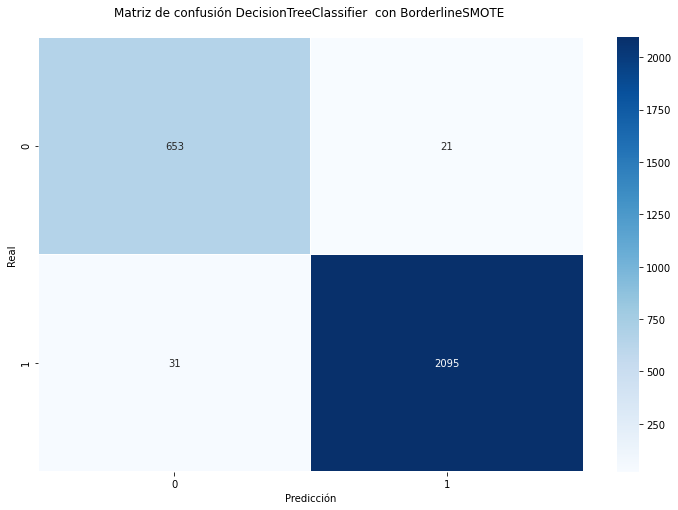

In [130]:
matrixDTC = confusion_matrix(y_test,y_pred)
dataframe = pd.DataFrame(matrixDTC)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe,
            annot = True,
            cbar = True,
            linewidths=0.1, 
            fmt=".0f", 
            cmap="Blues"
            )
plt.title("Matriz de confusión DecisionTreeClassifier  con BorderlineSMOTE \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

---
* Ahora entrenaremos un RandomForestClassifier bajo la misma estrategia:
---

In [131]:
modelRFC = RandomForestClassifier()
muestreoRFC = BorderlineSMOTE(random_state=42,
                           sampling_strategy='not majority',
                           n_jobs = 4)

X, y = muestreoRFC.fit_resample(baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
modelRFC.fit(X_train, y_train)
y_pred = modelRFC.predict(X_test)
print('\n Métricas del RandomForestClassifier en entrenamiento con BorderlineSMOTE:\n\n')
print(classification_report(y_test, y_pred))


 Métricas del RandomForestClassifier en entrenamiento con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2107
           1       0.95      0.99      0.97      2115

    accuracy                           0.97      4222
   macro avg       0.97      0.97      0.97      4222
weighted avg       0.97      0.97      0.97      4222



In [132]:
X,y= baseGetDummies.drop('RangoDiasSigCompra',axis=1), baseGetDummies.RangoDiasSigCompra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
print('\n Métricas del RandomForestClassifier  en testeo con BorderlineSMOTE:\n\n')
y_predRFC = modelRFC.predict(X_test)
print(classification_report(y_test, y_predRFC))


 Métricas del RandomForestClassifier  en testeo con BorderlineSMOTE:


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       674
           1       0.99      1.00      0.99      2126

    accuracy                           0.99      2800
   macro avg       0.99      0.98      0.98      2800
weighted avg       0.99      0.99      0.99      2800



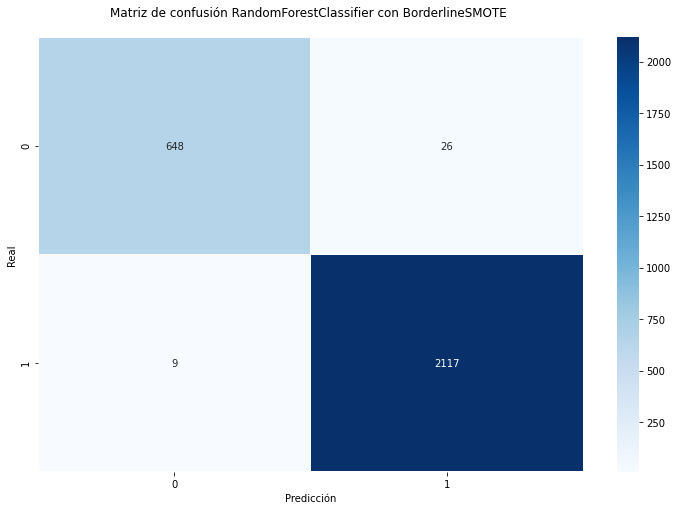

In [133]:
matrixRFC = confusion_matrix(y_test,y_predRFC)
dataframe = pd.DataFrame(matrixRFC)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe,
            annot = True,
            cbar = True,
            linewidths=0.1, 
            fmt=".0f", 
            cmap="Blues"
            )
plt.title("Matriz de confusión RandomForestClassifier con BorderlineSMOTE \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

---
* En los dos algoritmos tenemos un poco de error en la clasificación de la clase 3 y 4, aún así estas no son tan relevantes clasificarlas puesto que:

Clase 3: Clientes que comprarán a 120 días

Clase 4: Clientes a los que no se les clasifica un intervalo de compra por falta de datos

---

* Al comparar los scores del RandomForestClassifier y del DecisionTreeClassifier ambos tienen muy buena clasificación, aún así, vamos a descartar el RandomForestClassifier puesto que a la larga es un algoritmo "de caja negra" cuyo factor de aleatoriedad no se puede controlar en los arboles.

* Adicional a lo anterior, otra causa para descartarlo es nuestro conjunto de datos con el que lo entrenamos ya que es considerablemente "pequeño" para un clasificador como el RandomForestClassifier y tener varios árboles iterando en un conjunto de datos pequeño con varias clases no nos genera confianza.

* El DecisionTreeClassifier es un algoritmo simple que nos ha dado buenos resultados para el reto, se puede interpretar relativamente fácil y adicional a esto se puede "controlar" toda vez que no tiene ese factor de aleatoriedad.

---

In [134]:
#Parámetros del BorderlineSMOTE para el DecisionTreeClassifier:
muestreoDTC.get_params

<bound method BaseEstimator.get_params of BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=4,
                random_state=42, sampling_strategy='not majority')>

In [135]:
#Generar Probabilidades
y_predRFC_probab = modelRFC.predict_proba(X)
y_predDTC_probab = modelDTC.predict_proba(X)
y_predDTC_val = modelDTC.predict(X)

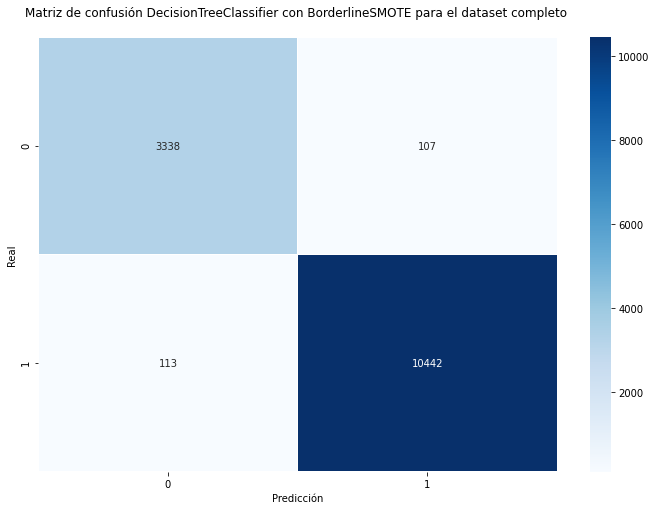

In [136]:
matrixDTC_F = confusion_matrix(y,y_predDTC_val)
dataframe = pd.DataFrame(matrixDTC_F)
plt.figure(figsize = (10,7))
sns.heatmap(dataframe,
            annot = True,
            cbar = True,
            linewidths=0.1,
            fmt=".0f", 
            cmap="Blues"
            )
plt.title("Matriz de confusión DecisionTreeClassifier con BorderlineSMOTE para el dataset completo \n"), plt.tight_layout()
plt.ylabel("Real"), plt.xlabel("Predicción")
plt.show()

In [137]:
print('\n Métricas del DecisionTreeClassifier con BorderlineSMOTE para el dataset completo:\n\n')
print(classification_report(y,y_predDTC_val))


 Métricas del DecisionTreeClassifier con BorderlineSMOTE para el dataset completo:


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3445
           1       0.99      0.99      0.99     10555

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [138]:
y_predDTC_val = pd.DataFrame(y_predDTC_val)

y_predDTC_probab = pd.DataFrame(y_predDTC_probab)
y_predDTC_probab.to_excel("probabilidades_DTC.xlsx")  

y_predRFC_probab = pd.DataFrame(y_predRFC_probab)
y_predRFC_probab.to_excel("probabilidades_RFC.xlsx")


## Ahora vamos a hacer la predicción para el mes de Octubre 2020

In [ ]:
#Descomprimimos el conjunto de datos:
!unrar x -Y "/content/Bavaria_Colombia/data/Base_Consolidada.rar" "/content/drive/path/output_folder/"

#Importamos el conjunto de datos:
base_nueva = pd.read_csv("/content/drive/path/output_folder/BaseConsolidada.csv")
base_nueva = base_nueva.fillna("")
base_nueva['Fecha'] = pd.to_datetime(base_nueva['Fecha'], format='%Y/%m/%d')

#Dividimos Histórico + 1 mes
baseHist = base_nueva[(base_nueva['Fecha'] <= datetime(2020,9,1))].reset_index(drop=True)
baseSigMes = base_nueva[(base_nueva['Fecha'] == datetime(2020,9,1))].reset_index(drop=True)

In [152]:
baseUsuarios = pd.DataFrame(baseHist['Cliente'].unique())
baseUsuarios.columns = ['Cliente']
baseSigMes_1Compra = baseSigMes.groupby('Cliente').Fecha.min().reset_index()
baseSigMes_1Compra.loc[baseSigMes_1Compra.Fecha=="2020-09-01",'Fecha']="2020-10-01"
baseSigMes_1Compra['Fecha'] = pd.to_datetime(baseSigMes_1Compra['Fecha'], format='%Y/%m/%d')
baseSigMes_1Compra.columns = ['Cliente','FechaProxCompra']
baseSigMes_1Compra.shape
FechaUltCompra = baseHist.groupby('Cliente').Fecha.max().reset_index()
FechaUltCompra.columns = ['Cliente','FechaUltCompra']
baseFechasCompra = pd.merge(FechaUltCompra,baseSigMes_1Compra,on='Cliente',how='left')
baseFechasCompra['DiasSigCompra'] = (baseFechasCompra['FechaProxCompra'] - baseFechasCompra['FechaUltCompra']).dt.days
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra[['Cliente','DiasSigCompra']],on='Cliente',how='left')

* Calcularemos el RFM:

In [153]:
#Recencia

baseDiasRecencia = baseHist.groupby('Cliente').Fecha.max().reset_index()
baseDiasRecencia.columns = ['Cliente','FechaUltCompra']
baseDiasRecencia['Recencia'] = (baseDiasRecencia['FechaUltCompra'].max() - baseDiasRecencia['FechaUltCompra']).dt.days
baseUsuarios = pd.merge(baseUsuarios, baseDiasRecencia[['Cliente','Recencia']], on='Cliente')
baseRecenciaClust = baseUsuarios[['Recencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseRecenciaClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=3)
kmeans.fit(baseUsuarios[['Recencia']])
baseUsuarios['RecenciaCluster'] = kmeans.predict(baseUsuarios[['Recencia']])
def OrdenCluster(nombreCluster, etiqueta,df,ascending):
    new_nombreCluster = 'new_' + nombreCluster
    clustOrdenados = df.groupby(nombreCluster)[etiqueta].mean().reset_index()
    clustOrdenados = clustOrdenados.sort_values(by=etiqueta,ascending=ascending).reset_index(drop=True)
    clustOrdenados['index'] = clustOrdenados.index
    ClustOrdenAsc = pd.merge(df,clustOrdenados[[nombreCluster,'index']], on=nombreCluster)
    ClustOrdenAsc = ClustOrdenAsc.drop([nombreCluster],axis=1)
    ClustOrdenAsc = ClustOrdenAsc.rename(columns={"index":nombreCluster})
    return ClustOrdenAsc
baseUsuarios = OrdenCluster('RecenciaCluster', 'Recencia',baseUsuarios,False)
baseUsuarios.groupby('RecenciaCluster')['Recencia'].describe()

#Frecuencia

baseFrecuencia = baseHist.groupby('Cliente').Fecha.count().reset_index()
baseFrecuencia.columns = ['Cliente','Frecuencia']
baseUsuarios = pd.merge(baseUsuarios, baseFrecuencia, on='Cliente')
baseFrecuenciaClust = baseUsuarios[['Frecuencia']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseFrecuenciaClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Frecuencia']])
baseUsuarios['FrecuenciaCluster'] = kmeans.predict(baseUsuarios[['Frecuencia']])
baseUsuarios = OrdenCluster('FrecuenciaCluster', 'Frecuencia',baseUsuarios,True)
baseUsuarios.groupby('FrecuenciaCluster')['Frecuencia'].describe()

# Monetización

baseHist['Monetizacion'] = baseHist['nr']
baseMonetizacion = baseHist.groupby('Cliente').Monetizacion.sum().reset_index()
baseUsuarios = pd.merge(baseUsuarios, baseMonetizacion, on='Cliente')
baseMonetizacionClust = baseUsuarios[['Monetizacion']]
distancias = []
rango = range(1,10)
for i in rango:
    grupos = KMeans(n_clusters=i, max_iter=100)
    grupos = grupos.fit(baseMonetizacionClust)
    distancias.append(grupos.inertia_)
kmeans = KMeans(n_clusters=4)
kmeans.fit(baseUsuarios[['Monetizacion']])
baseUsuarios['MonetizacionCluster'] = kmeans.predict(baseUsuarios[['Monetizacion']])
baseUsuarios = OrdenCluster('MonetizacionCluster', 'Monetizacion',baseUsuarios,True)
baseUsuarios.groupby('MonetizacionCluster')['Monetizacion'].describe()

# Segmentación general (Feature adicional):
baseUsuarios['ScoreGeneral']= baseUsuarios['RecenciaCluster'] + \
                              baseUsuarios['FrecuenciaCluster'] + \
                              baseUsuarios['MonetizacionCluster']
indicadoresGenerales = baseUsuarios.groupby('ScoreGeneral')['Recencia','Frecuencia','Monetizacion'].mean()

#Segmentamos y clasificamos:

baseUsuarios['Segmento'] = 'Valor-Bajo'
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==2,'Segmento'] = 'Valor-Medio' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==3,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==4,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==5,'Segmento'] = 'Valor-Alto' 
baseUsuarios.loc[baseUsuarios['ScoreGeneral']==6,'Segmento'] = 'Valor-Medio' 

In [154]:
#Creamos un dataFrame solamente con el idCliente y la fechaCompra
baseFechasCompra = baseHist[['Cliente','Fecha']]

#Conversión formato fecha
baseFechasCompra['diaCompra'] = baseHist['Fecha'].dt.date

baseFechasCompra = baseFechasCompra.sort_values(['Cliente','Fecha'])

#Eliminamos duplicados
baseFechasCompra = baseFechasCompra.drop_duplicates(subset=['Cliente','Fecha'],keep='first')

#Hacemos un lag para las fechas de compra de acuerdo a los históricos

baseFechasCompra['MesCompra_1'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(1)
baseFechasCompra['MesCompra_2'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(2)
baseFechasCompra['MesCompra_3'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(3)
baseFechasCompra['MesCompra_4'] = baseFechasCompra.groupby('Cliente')['diaCompra'].shift(4)

baseFechasCompra['DiasTransc'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_1']).dt.days
baseFechasCompra['DiasTransc2'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_2']).dt.days
baseFechasCompra['DiasTransc3'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_3']).dt.days
baseFechasCompra['DiasTransc4'] = (baseFechasCompra['diaCompra'] - baseFechasCompra['MesCompra_4']).dt.days

baseDiasCompras = baseFechasCompra.groupby('Cliente').agg({'DiasTransc': ['mean','std']}).reset_index()
baseDiasCompras.columns = ['Cliente', 'DiasTranscMean','DiasTranscStd']
baseFechasCompra_last = baseFechasCompra.drop_duplicates(subset=['Cliente'],keep='last')

baseFechasCompra_last = baseFechasCompra_last.fillna(0)
baseFechasCompra_last = pd.merge(baseFechasCompra_last, baseDiasCompras, on='Cliente')
baseFechasCompra_last = baseFechasCompra_last.fillna(0)
baseUsuarios = pd.merge(baseUsuarios, baseFechasCompra_last[
                                                            ['Cliente',
                                                             'DiasTransc',
                                                             'DiasTransc2',
                                                             'DiasTransc3',
                                                             'DiasTransc4',
                                                             'DiasTranscMean',
                                                             'DiasTranscStd']
                                                            ],on='Cliente')
# Get Dummies:

baseGetDummies = baseUsuarios.copy()
baseGetDummies = pd.get_dummies(baseGetDummies)
baseGetDummies['RangoDiasSigCompra'] = 0
baseGetDummies.loc[baseGetDummies.DiasSigCompra<=31,'RangoDiasSigCompra'] = 1
baseGetDummies.loc[baseGetDummies.DiasSigCompra>31,'RangoDiasSigCompra'] = 0
baseGetDummies = baseGetDummies.drop('DiasSigCompra',axis=1)

In [168]:
# Definimos el dataset
X = baseGetDummies.drop('RangoDiasSigCompra',axis=1)

In [174]:
# Realizamos la predicción
y_predRFC = modelRFC.predict_proba(X)

#Generar Probabilidades
y_predRFC_probabilidades_Octubre = pd.DataFrame(modelRFC.predict_proba(X))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feea7c41190>,
      dtype=object)

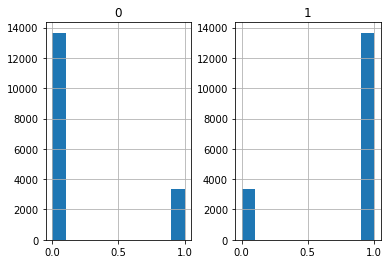

In [175]:
y_predRFC_probabilidades_Octubre.hist()

In [176]:
y_predRFC_probabilidades_Octubre

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
17005,0.0,1.0
17006,0.0,1.0
17007,0.0,1.0
17008,0.0,1.0


Ahora renombraremos las columnas de acuerdo a las clases predichas:

In [189]:
y_predRFC_probabilidades_Octubre.columns=['No compra','Si Compra']
PrediccionesOctubre = pd.concat([X, y_predRFC_probabilidades_Octubre], axis=1)
PrediccionesOctubre = PrediccionesOctubre[['Cliente', 'No compra','Si Compra']]
PrediccionesOctubre.to_excel("PrediccionesOctubre.xlsx")  
PrediccionesOctubre

,Cliente,No compra,Si Compra
0,10,0.0,1.0
1,24,0.0,1.0
2,26,0.0,1.0
3,33,0.0,1.0
4,57,0.0,1.0
...,...,...,...
17005,5788,0.0,1.0
17006,9794,0.0,1.0
17007,13069,0.0,1.0
17008,14357,0.0,1.0
